# TabPFN-TS Prediction Visualization
This notebook visualizes predictions from TabPFN-TS on various GIFT-Eval datasets.

In [21]:
import os
from dotenv import load_dotenv
from pathlib import Path

load_dotenv()

# Configuration
# dataset_storage_path = Path(os.getenv("DATASET_STORAGE_PATH"))
root_output_dir = Path("tabpfn_time_series/experimental/visualization/figures_June2025")

root_output_dir.mkdir(parents=True, exist_ok=True)


In [67]:
from pathlib import Path

import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame

from gift_eval.data import Dataset
from gift_eval.dataset_definition import ALL_DATASETS
from gift_eval.tabpfn_ts_wrapper import TabPFNTSPredictor
from tabpfn_time_series.plot import plot_pred_and_actual_ts
from gift_eval.evaluate import construct_evaluation_data
from tabpfn_time_series.predictor import TabPFNMode

def load_dataset(dataset_name, term="short", dataset_storage_path=None):
    """Load a dataset from GIFT-Eval."""
    if dataset_storage_path is None:
        dataset_storage_path = Path("../gift_eval/data")
    
    # Initialize the dataset
    # First check if we need to convert to univariate
    to_univariate = False
    temp_dataset = Dataset(
        name=dataset_name,
        term=term,
        to_univariate=False,
        storage_path=dataset_storage_path,
    )
    if temp_dataset.target_dim > 1:
        to_univariate = True
    
    # Load the actual dataset
    dataset = Dataset(
        name=dataset_name,
        term=term,
        to_univariate=to_univariate,
        storage_path=dataset_storage_path,
    )
    
    return dataset


def get_predictions(dataset, item_id=0):
    """Generate predictions for a specific item in the dataset."""
    # Initialize predictor
    tabpfn_predictor = TabPFNTSPredictor(
        ds_prediction_length=dataset.prediction_length,
        ds_freq=dataset.freq,
        tabpfn_mode = TabPFNMode.LOCAL,
    )
    
    # Get train and test data for the specific item
    eval_data = dataset.test_data
    random_sample = list(eval_data)[item_id]
    
    # Generate predictions
    predictions = tabpfn_predictor.predict([random_sample[0]])

    train_tsdf = tabpfn_predictor.convert_to_timeseries_dataframe([random_sample[0]])
    test_tsdf = tabpfn_predictor.convert_to_timeseries_dataframe([random_sample[1]])
    
    return train_tsdf, test_tsdf, predictions


def convert_to_tsdf(gluonts_data, is_train=True):
    """Convert GluonTS ListDataset to TimeSeriesDataFrame."""
    all_series = []
    print(f"gluonts_data: {gluonts_data}")
    
    # for i, entry in enumerate(gluonts_data):
    for i, entry in gluonts_data.groupby(level="item_id"):
        target = entry["target"]
        start_date = pd.Timestamp(entry["start"])
        _ = entry["feat_static_cat"][0] if "feat_static_cat" in entry else 0
        
        # Create date range
        dates = pd.date_range(
            start=start_date,
            periods=len(target),
            freq=pd.infer_freq(pd.date_range(start=start_date, periods=5))
        )
        
        # Create DataFrame
        series_df = pd.DataFrame({
            "timestamp": dates,
            "item_id": i,
            "target": target
        })
        series_df.set_index(["item_id", "timestamp"], inplace=True)
        all_series.append(series_df)
    
    # Combine all series
    combined_df = pd.concat(all_series)
    tsdf = TimeSeriesDataFrame(combined_df)
    
    return tsdf


def convert_forecast_to_tsdf(forecast, test_tsdf):
    """Convert GluonTS forecast to TimeSeriesDataFrame."""
    all_series = []
    
    for i, fcast in enumerate(forecast):
        # Get the item's test data to extract timestamps
        item_test = test_tsdf.loc[i]
        timestamps = item_test.index
        
        # Create DataFrame with mean prediction and quantiles
        series_data = {
            "timestamp": timestamps,
            "item_id": i,
            "target": fcast.mean
        }
        
        # Add quantiles
        for q in [0.1, 0.5, 0.9]:
            q_str = str(q)
            series_data[q_str] = fcast.quantile(q)
        
        series_df = pd.DataFrame(series_data)
        series_df.set_index(["item_id", "timestamp"], inplace=True)
        all_series.append(series_df)
    
    # Combine all series
    combined_df = pd.concat(all_series)
    pred_tsdf = TimeSeriesDataFrame(combined_df)
    
    return pred_tsdf


def visualize_dataset(dataset_name, term="short", item_id=0):
    print(f"\n## Dataset: {dataset_name} (term: {term})")
    
    # Use construct_evaluation_data to get dataset
    sub_datasets = construct_evaluation_data(
        dataset_name=dataset_name,
        dataset_storage_path=dataset_storage_path,
        terms=[term]
    )
    
    if not sub_datasets:
        print(f"No datasets found for {dataset_name} with term {term}")
        return
    
    # Get the first dataset that matches the term
    dataset, dataset_metadata = sub_datasets[0]
    
    print(f"Prediction length: {dataset.prediction_length}")
    print(f"Frequency: {dataset.freq}")
    print(f"Target dimension: {dataset.target_dim}")
    print(f"Dataset full name: {dataset_metadata['full_name']}")
    
    # Generate predictions
    train_tsdf, test_tsdf, predictions = get_predictions(dataset, item_id)
    
    # Convert to TimeSeriesDataFrame
    pred_tsdf = convert_forecast_to_tsdf(predictions, test_tsdf)
    
    # Visualize ground truth and predictions in the same plot
    print("\nGround truth and predictions:")
    output_dir = root_output_dir / term
    output_dir.mkdir(parents=True, exist_ok=True)
    plot_pred_and_actual_ts(pred_tsdf, train_tsdf, test_tsdf, item_ids=[item_id], show_points=True,
                            hide_legend=True,
                            title=f"{dataset_name}/{term}",
                            save_path=output_dir / f"{dataset_name.replace('/', '-')}-{term}.pdf")
    
    # Compute MASE score
    mase_results = quick_mase_evaluation(train_tsdf, test_tsdf, pred_tsdf, dataset.prediction_length)
    
    return mase_results


def visualize_multiple_items(dataset_name, term="short", item_ids=[0, 1, 2]):
    print(f"\n## Dataset: {dataset_name} (term: {term})")
    
    # Load dataset
    # try:
    dataset = load_dataset(dataset_name, term, dataset_storage_path)
    print(f"Prediction length: {dataset.prediction_length}")
    print(f"Frequency: {dataset.freq}")
    print(f"Target dimension: {dataset.target_dim}")
    print(f"possible item ids: {dataset.__dict__.keys()}")
    # print(f"Number of time series: {len(dataset.gluonts_dataset.train_data)}")
    
    # Generate predictions
    train_tsdf, test_tsdf, predictions = get_predictions(dataset, item_id = 7)
    print(f"Number of time series: {train_tsdf.item_ids}")
    
    # Convert to TimeSeriesDataFrame
    # print(f"train_data: {train_data}")
    # print(f"test_data: {test_data}")
    # print(f"predictions: {predictions}")
    # train_tsdf = convert_to_tsdf(train_data, is_train=True)
    # test_tsdf = convert_to_tsdf(test_data, is_train=False)
    pred_tsdf = convert_forecast_to_tsdf(predictions, test_tsdf)
    
    print(f"train_tsdf.item_ids: {train_tsdf.item_ids}")
    
    # Visualize multiple items
    valid_item_ids = [i for i in item_ids if i < len(train_tsdf.item_ids)]
    if not valid_item_ids:
        print(f"No valid item IDs found. Max item ID is {len(train_tsdf)-1}")
        return False
    
    print("\nGround truth and predictions for multiple items:")
    output_dir = root_output_dir / term
    output_dir.mkdir(parents=True, exist_ok=True)
    plot_pred_and_actual_ts(pred_tsdf, train_tsdf, test_tsdf, item_ids=valid_item_ids, show_points=True, 
                            title=f"{dataset_name}/{term}",
                            save_path=output_dir / f"{dataset_name.replace('/', '-')}-{term}.pdf")
    
    # Compute MASE score
    mase_results = quick_mase_evaluation(train_tsdf, test_tsdf, pred_tsdf, dataset.prediction_length)
    
    return mase_results
    # except Exception as e:
    #     print(f"Error visualizing {dataset_name}: {str(e)}")
    #     return False


## Rosen: MASE

In [23]:
def quick_mase_evaluation(train_tsdf, test_tsdf_ground_truth, pred, prediction_length):
    """
    Compute MASE scores for each item_id and overall average.
    
    Returns:
        pd.DataFrame: DataFrame with columns ['item_id', 'mase_score']
                     Last row contains average with item_id='AVERAGE'
    """
    from autogluon.timeseries.metrics.point import MASE
    from autogluon.timeseries.utils.datetime import get_seasonality
    import pandas as pd
    
    mase_results = []
    
    # Loop over each item_id and calculate MASE score
    for item_id, df_item in train_tsdf.groupby(level="item_id"):
        mase_computer = MASE()
        mase_computer.clear_past_metrics()
        
        pred["mean"] = pred["target"]
        
        mase_computer.save_past_metrics(
            data_past=train_tsdf.loc[[item_id]],
            seasonal_period=get_seasonality(train_tsdf.freq),
        )
        
        mase_score = mase_computer.compute_metric(
            data_future=test_tsdf_ground_truth.loc[[item_id]], #.slice_by_timestep(-prediction_length - 1, -1),
            predictions=pred.loc[[item_id]],
        )
        
        mase_results.append({
            'item_id': item_id,
            'mase_score': mase_score
        })
    
    # Create DataFrame with individual results
    results_df = pd.DataFrame(mase_results)
    
    # Add average row
    average_mase = results_df['mase_score'].mean()
    average_row = pd.DataFrame({
        'item_id': ['AVERAGE'],
        'mase_score': [average_mase]
    })
    
    # Combine results
    final_results = pd.concat([results_df, average_row], ignore_index=True)
    
    return final_results

## Available Datasets
Let's see what datasets are available in GIFT-Eval.

In [39]:
# Print available datasets
print(f"Available datasets: {len(ALL_DATASETS)}")
for i, dataset in enumerate(ALL_DATASETS):
    print(f"{i+1}. {dataset}")

Available datasets: 55
1. LOOP_SEATTLE/5T
2. restaurant
3. m4_weekly
4. solar/D
5. ett1/D
6. ett2/15T
7. m4_hourly
8. us_births/M
9. electricity/15T
10. saugeenday/M
11. bitbrains_rnd/H
12. LOOP_SEATTLE/H
13. LOOP_SEATTLE/D
14. m4_quarterly
15. electricity/D
16. hospital
17. solar/10T
18. kdd_cup_2018_with_missing/H
19. saugeenday/W
20. ett1/W
21. bitbrains_fast_storage/5T
22. bizitobs_l2c/H
23. covid_deaths
24. m4_monthly
25. electricity/H
26. car_parts_with_missing
27. ett1/15T
28. jena_weather/10T
29. hierarchical_sales/W
30. SZ_TAXI/15T
31. bitbrains_fast_storage/H
32. us_births/D
33. ett2/D
34. temperature_rain_with_missing
35. ett2/W
36. jena_weather/D
37. kdd_cup_2018_with_missing/D
38. hierarchical_sales/D
39. ett1/H
40. bizitobs_l2c/5T
41. m4_daily
42. jena_weather/H
43. us_births/W
44. ett2/H
45. m4_yearly
46. bitbrains_rnd/5T
47. solar/H
48. bizitobs_service
49. electricity/W
50. SZ_TAXI/H
51. M_DENSE/H
52. M_DENSE/D
53. solar/W
54. bizitobs_application
55. saugeenday/D


In [25]:
HUGE_DATASETS = [
    "bitbrains_rnd/5T",
    "bitbrains_fast_storage/5T",
    "electricity/15T",
    "LOOP_SEATTLE/5T",
    "LOOP_SEATTLE/H",
    "temperature_rain_with_missing",
]

## Visualization

In [26]:
dataset_storage_path = Path("gift_eval/data")


In [ ]:
dataset = load_dataset(dataset_name, term, dataset_storage_path)

In [ ]:
# sub_datasets bizitobs_service

In [98]:
dataset_name = "ett2/15T"
term = "short"
print(f"\n## Dataset: {dataset_name} (term: {term})")
    
# Use construct_evaluation_data to get dataset
sub_datasets = construct_evaluation_data(
    dataset_name=dataset_name,
    dataset_storage_path=dataset_storage_path,
    terms=[term]
)

if not sub_datasets:
    print(f"No datasets found for {dataset_name} with term {term}")
    # return

# Get the first dataset that matches the term
dataset, dataset_metadata = sub_datasets[0]

print(f"Prediction length: {dataset.prediction_length}")
print(f"Frequency: {dataset.freq}")
print(f"Target dimension: {dataset.target_dim}")
print(f"Dataset full name: {dataset_metadata['full_name']}")

# Generate predictions
# train_tsdf, test_tsdf, predictions = get_predictions(dataset, 2)
# train_tsdf
list(dataset.test_data)[0]
# dataset.test_data.dataset

# Generate predictions
# train_tsdf, test_tsdf, predictions = get_predictions(dataset, 2)
# train_tsdf

# # Convert to TimeSeriesDataFrame
# train_tsdf = convert_to_tsdf(train_tsdf, is_train=True)
# test_tsdf = convert_to_tsdf(test_tsdf, is_train=False)


## Dataset: ett2/15T (term: short)
Prediction length: 48
Frequency: 15T
Target dimension: 7
Dataset full name: ett2/15T/short


({'item_id': 'item_0_dim0',
  'start': Period('2016-07-01 00:00', '15T'),
  'freq': '15T',
  'target': array([41.13 , 39.622, 38.868, ..., 30.827, 31.497, 31.329], dtype=float32)},
 {'item_id': 'item_0_dim0',
  'start': Period('2018-06-16 20:00', '15T'),
  'freq': '15T',
  'target': array([34.01 , 34.847, 37.109, 34.094, 36.272, 40.46 , 43.224, 39.455,
         40.125, 43.559, 44.229, 39.036, 39.622, 38.868, 38.868, 40.292,
         36.69 , 34.68 , 34.429, 36.607, 37.277, 33.591, 31.916, 29.738,
         32.167, 35.853, 35.518, 33.591, 33.005, 28.984, 33.423, 31.916,
         31.581, 29.905, 27.057, 24.293, 30.073, 29.821, 26.89 , 26.806,
         29.989, 34.094, 31.413, 33.172, 30.827, 32.502, 30.408, 29.486],
        dtype=float32)})

In [75]:
dataset.gluonts_dataset.

dict_keys(['base_dataset', 'transformation', 'is_train'])

In [78]:
from datasets import load_dataset as chronos_load_dataset
dataset = chronos_load_dataset("autogluon/chronos_datasets", "monash_tourism_monthly")
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'timestamp', 'target'],
        num_rows: 366
    })
})

/home/turbo/rosenyu/Github/tabpfn-time-series-exp/tabpfn_time_series/features/feature_transformer.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tsdf = pd.concat([train_tsdf, test_tsdf])



## Dataset: solar/W (term: short)
Prediction length: 8
Frequency: W-FRI
Target dimension: 1
Dataset full name: solar/W/short


GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]



Ground truth and predictions:


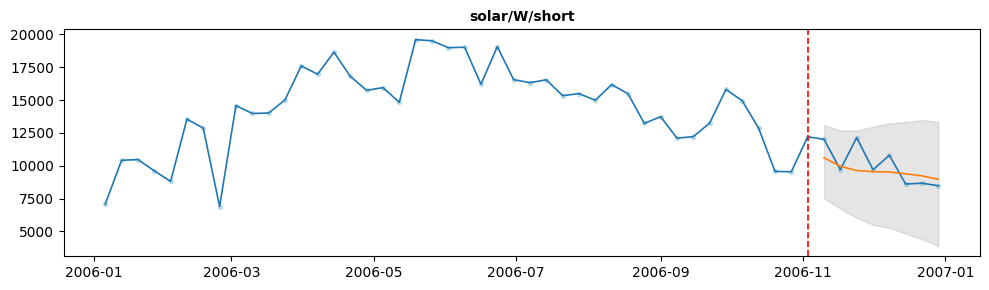

,item_id,mase_score
0,0,0.571689
1,AVERAGE,0.571689


In [62]:
mase_results = visualize_dataset("solar/W", term="short")
mase_results

/home/turbo/rosenyu/Github/tabpfn-time-series-exp/tabpfn_time_series/features/feature_transformer.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tsdf = pd.concat([train_tsdf, test_tsdf])



## Dataset: ett2/15T (term: short)
Prediction length: 48
Frequency: 15T
Target dimension: 7
possible item ids: dict_keys(['hf_dataset', 'freq', 'target_dim', 'gluonts_dataset', 'term', 'name', 'prediction_length'])


GPU 0::   0%|          | 0/1 [00:00<?, ?it/s]

GPU 0:: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Number of time series: Index([0], dtype='int64', name='item_id')
train_tsdf.item_ids: Index([0], dtype='int64', name='item_id')

Ground truth and predictions for multiple items:


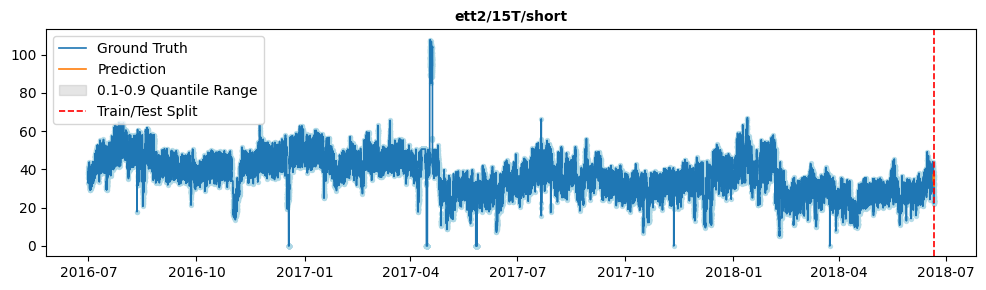

,item_id,mase_score
0,0,2.359851
1,AVERAGE,2.359851


In [68]:
mase_results = visualize_multiple_items("ett2/15T", term="short", item_ids=[0, 1, 6])
mase_results